In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
import math
import tqdm
from qulacs import PauliOperator, Observable, QuantumState
#GPU版をインストールしている場合のみ
#from qulacs import QuantumStateGpu
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs.state import inner_product
from qulacs.gate import *
from qulacs import ParametricQuantumCircuit

In [6]:
import scipy.optimize

def define_Heisenberg_Hamiltonian(operator,ListOfInt):
    nqubits = operator.get_qubit_count()
    for k in range(len(ListOfInt)):
        operator.add_operator(1.0,"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
        operator.add_operator(1.0,"X {0}".format(ListOfInt[k][0])+"X {0}".format(ListOfInt[k][1])) 
        operator.add_operator(1.0,"Y {0}".format(ListOfInt[k][0])+"Y {0}".format(ListOfInt[k][1])) 
    return operator

def define_Z_field(operator):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(1.0,"Z {0}".format(k)) 
    return operator


def hamiltonian_ansatz(hamiltonian,driver,max_depth):
    i=0

    nqubits = hamiltonian.get_qubit_count()
    ansatz_circuit =ParametricQuantumCircuit(nqubits)


    for depth in range(max_depth):
        for j in range(hamiltonian.get_term_count()):
            pauli = hamiltonian.get_term(j)

            # Get the subscript of each pauli symbol
            index_list = pauli.get_index_list()

            # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
            pauli_id_list = pauli.get_pauli_id_list()

            ansatz_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, 0.0)
            i+=1

        for j in range(driver.get_term_count()):
            pauli = driver.get_term(j)

            # Get the subscript of each pauli symbol
            index_list = pauli.get_index_list()
            # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
            pauli_id_list = pauli.get_pauli_id_list()

            ansatz_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, 0.0)
            i+=1    
 #   print(ansatz_circuit.get_parameter_count())
#    print(ansatz_circuit)
    return ansatz_circuit

def cost_func_ansatz(ansatz_circuit,hamiltonian,para):
    nqubits = ansatz_circuit.get_qubit_count()
    state = QuantumState(nqubits)

    parameter_count = ansatz_circuit.get_parameter_count()



    for i in range(parameter_count):
        ansatz_circuit.set_parameter(i,para[i])
        
    ansatz_circuit.update_quantum_state(state)

    return  hamiltonian.get_expectation_value(state)


def open_square_Heisenberg_anti_ferro(length):
    nqubits = length**2
    
    vertical = [[i,(i+1)%length] for i in range(length-1)]
    horizontal = [[(i%length)*length,((i+1)%length)*length] for i in range(length-1)]

    ListOfInt = []
    for pair in vertical:
        for i in range(length):
            ListOfInt.append([pair[0]+i*length,pair[1]+i*length])

    for pair in horizontal:
        for i in range(length):
            ListOfInt.append([pair[0]+i,pair[1]+i])

#    print(ListOfInt)
    
    hamiltonian = Observable(nqubits)
    hamiltonian = define_Heisenberg_Hamiltonian(hamiltonian,ListOfInt)

    return hamiltonian




# qulacsのbackpropを用いたVQEの実装例
- 正方格子ハイゼンベルク模型
- ハンザッツはハミルトニアンから構成（QAOA的な）
- scipy.optimizeのBFGSで、勾配をbackpropで与えた場合とそうでない場合で比較

In [52]:
max_depth =5
length = 3
nqubits = length**2
hamiltonian = open_square_Heisenberg_anti_ferro(length)
driver = Observable(nqubits)
for i in range(nqubits):
    driver.add_operator(1.0,f"X {i}")
    driver.add_operator(1.0,f"Z {i}")

ansatz_circuit = hamiltonian_ansatz(hamiltonian,driver,max_depth)
num_paras = ansatz_circuit.get_parameter_count()

def cost(para):
    return cost_func_ansatz(ansatz_circuit,hamiltonian,para)

def get_gradient(cost,parameters):
    num_paras = len(parameters)
    epsilon = 1e-6
    

    gradient = np.array([0.0 for i in range(num_paras)])
    cost_val = cost(parameters) 

    #MPI並列化したいループ
    for j in range(num_paras):

        tmp = parameters[j]  

        parameters[j] = tmp + epsilon  
        plus_epsilon = cost(parameters)

        gradient[j] = (plus_epsilon - cost_val) / ( epsilon)
        parameters[j] = tmp  
        #MPI並列化したいループ終わり
    return gradient

def grad(para):
    return get_gradient(cost,np.array(para))

def grad_backprop(para):
    parameter_count = ansatz_circuit.get_parameter_count()
    for i in range(parameter_count):
        ansatz_circuit.set_parameter(i,para[i])
        
    return     ansatz_circuit.backprop(hamiltonian)


scipyで最適化（勾配はoptimizeでおそらく数値微分）

         Current function value: -18.851852
         Iterations: 200
         Function evaluations: 55013
         Gradient evaluations: 203
time 117.67649412155151 sec


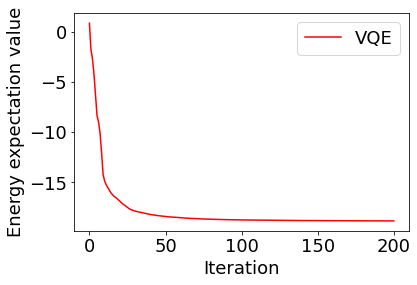

In [58]:
cost_history = []
init_theta_list = [random.random() for i in range(ansatz_circuit.get_parameter_count())]
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-3}

st_time = time.time()
opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)),options = options)
print("time",time.time()-st_time,"sec")

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

         Current function value: -18.723228
         Iterations: 200
         Function evaluations: 201
         Gradient evaluations: 201
time 7.93417501449585 sec


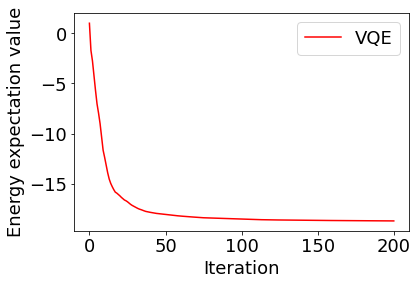

In [57]:
cost_history = []
init_theta_list = [random.random() for i in range(ansatz_circuit.get_parameter_count())]
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-3}

st_time = time.time()
opt = scipy.optimize.minimize(cost, init_theta_list,jac = grad_backprop,
               method=method,
               callback=lambda x: cost_history.append(cost(x)),options = options)
print("time",time.time()-st_time,"sec")

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

In [47]:
opt.fun

-18.982808076342693

qulacsに搭載されているランチョス法で答えを確認

In [48]:
state = QuantumState(length**2)
state.set_Haar_random_state()
hamiltonian.solve_ground_state_eigenvalue_by_lanczos_method(state,50)

(-18.99730903421144+0j)

もう少しパラメータが多い系で、pythonのforでgradを計算した場合と、backpropを比較

In [59]:
max_depth =20
length = 3
nqubits = length**2
hamiltonian = open_square_Heisenberg_anti_ferro(length)
driver = Observable(nqubits)
for i in range(nqubits):
    driver.add_operator(1.0,f"X {i}")
    driver.add_operator(1.0,f"Z {i}")

ansatz_circuit = hamiltonian_ansatz(hamiltonian,driver,max_depth)
num_paras = ansatz_circuit.get_parameter_count()


init_theta_list = [random.random() for i in range(ansatz_circuit.get_parameter_count())]
st_time = time.time()
res_grad = grad(init_theta_list)
print("time",time.time()-st_time,"sec")

st_time = time.time()
res_grad = grad_backprop(init_theta_list)
print("time",time.time()-st_time,"sec")

time 6.762330055236816 sec
time 0.06421303749084473 sec
